In [2]:
import numpy as np

import torch

import matplotlib.pyplot as plt

from ray_transforms import get_ray_trafo, get_static_ray_trafo
from test_model_functions_swaped import get_net_corected_operator
# import random
import torch 


import os
from util import plots,hide_axis
from conf import config
from select_model_type_matrix import select_fwd_model_type,select_adj_model_type
from scipy import sparse
from util import get_op,Mat,plots,rand_shift_params,get_shift,error_for_y

def ISTA_obj_func(op,y,lam,x):
    return 1/(2)*np.linalg.norm((op(x)-y).reshape(y.size),2)**2+lam*np.linalg.norm(x.reshape(x.size),1)

class ISTA():
    def __init__(self,mu,lam,y,fw_op,adj_op):
        self.mu = mu
        self.lam = lam
        self.y = y
        self.fw_op = fw_op
        self.adj_op = adj_op
    
    def soft_shrink(self,x,alpha): 
        return np.sign(x) * np.maximum(np.abs(x)-alpha,0)

    def get_impl(self,x):
        r = self.fw_op(x) - self.y
        F_abl = self.adj_op(r)
        if type(F_abl) is not np.ndarray:
            F_abl = F_abl.asarray()
        x = self.soft_shrink(x-self.mu * F_abl, self.mu*self.lam)
        # x = np.maximum(x,0)
        return x

def im_norm(x):
    # if type(x) is odl.discr.discr_space.DiscretizedSpaceElement:
    #     x= x.asarray()
    x = x.reshape(x.size)
    return np.linalg.norm(x,2)

def sp(a,b):
    return a.reshape(a.size)@b.reshape(b.size)



In [3]:
gpu_idx = 0
device = f"cuda:{gpu_idx}" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
import astra
astra.set_gpu_index(gpu_idx)

Using cpu device


In [5]:
c = config('run_20220901_matrix_ISTA')
path = c.path
print(c.note)

ISTA training on 5 random operators with 5 u_v_shift correction only on phantom space again with better mu


In [6]:
c.mu,c.lam

(0.0002, 0.001)

In [7]:
rand_shift_dict = dict()
rand_shift_dict.update({"num_params":1})
rand_shift_dict.update({"amp_range":[0.03,0.05]})
rand_shift_dict.update({"freq_range":c.freq_range})
rand_shift_dict.update({"freq_shift_range":c.freq_shift_range})
rand_shift_dict

{'num_params': 1,
 'amp_range': [0.03, 0.05],
 'freq_range': [500, 5000],
 'freq_shift_range': [0, 6.283185307179586]}

In [8]:
tp = np.load(file='phantoms/test_phantoms_64_1.npy')
p = tp[0,:,:]
p.shape

(64, 64)

In [7]:
tp = np.load(file='phantoms/validation_phantoms_64_10.npy')
p = tp[1,:,:]
p.shape

(64, 64)

In [16]:
impl = 'astra_cpu'

# shift_params_list = c.shift_params_list
# shift = get_shift(c.shift_params)
# shift = get_shift(c.shift_params_list[0])
# shift = get_shift(np.array([[[0.05,1000,0],[0.05,1000,0]]]))
shift = get_shift(rand_shift_params(**rand_shift_dict))
ray_trafo = get_ray_trafo(c.x_res, c.y_res,c.num_angles,c.detector_points,DET_SHIFT=shift,detector_len=2,impl=impl)
domain = ray_trafo.domain
adj_domain = ray_trafo.adjoint.domain
# A = Mat(ray_trafo)
# def ray_trafo(x):
#     return domain.element((A@x.reshape(64**2)).reshape(64,64))
# def ray_trafo_adjoint(x):
#     return adj_domain.element((A.T@x.reshape(64**2)).reshape(64,64))
# ray_trafo.adjoint = ray_trafo_adjoint

static_ray_trafo = get_ray_trafo(c.x_res, c.y_res,c.num_angles,c.detector_points,detector_len=2,impl=impl)

# op_norm = ray_trafo.norm('estimate')

adj_norm_coef = im_norm(np.ones(64**2))/(ray_trafo.adjoint.domain.one()).norm()
norm_coef = im_norm(np.ones(64**2))/(ray_trafo.domain.one()).norm()

fileending = 'png'
doent_show = False
save_path = f'{path}Test/'
if not os.path.isdir(save_path):
    os.makedirs(save_path)

c.mu = 0.2
mu = c.mu

# mu = 0.0001
ceep_shift = False

ray_trafo = get_ray_trafo(c.x_res, c.y_res,c.num_angles,c.detector_points,DET_SHIFT=shift,detector_len=2)
# if c.load_A_s and ceep_shift:
#     A_s = sparse.load_npz(c.A_s_paths[0])
# else:
#     A_s = sparse.csr_matrix(Mat(ray_trafo,c.x_res, c.y_res, c.num_angles, c.detector_points))
A_s = sparse.load_npz("Matritzen/64_64_256_96_1_u_v_shift/ray_trafo_0.npz")
true_op = get_op(A_s,c.x_res, c.y_res, c.num_angles, c.detector_points)

static_ray_trafo = get_static_ray_trafo(c.x_res, c.y_res,c.num_angles,c.detector_points,detector_len=2)
if c.load_static_A_s:
    A_static_s = sparse.load_npz(c.static_A_s_path)
else:
    A_static_s = sparse.csr_matrix(Mat(static_ray_trafo,c.x_res, c.y_res,c.num_angles,c.detector_points))
static_op = get_op(A_static_s,c.x_res, c.y_res, c.num_angles, c.detector_points)


In [17]:
A_s = sparse.load_npz('Matritzen/64_64_256_96_1_u_v_shift/ray_trafo_0.npz')

In [18]:
y = true_op(p)
c.e_p=0.04
y_e = error_for_y(y, c.e_p)

In [19]:
# rt_norm = sparse.linalg.norm(A_static_s.T)
rt_norm = np.sqrt(np.linalg.norm((A_static_s.T@A_static_s).todense(),2))
rt_norm

1.7059635008394685

In [20]:
TA_static_s = torch.sparse_csr_tensor(A_static_s.indptr,A_static_s.indices,A_static_s.data,A_static_s.shape,dtype=float)
model = select_fwd_model_type(c,TA_static_s.to_dense().to(device))
AT_static_s = sparse.csr_matrix(A_static_s.T)
TAT_static_s = torch.sparse_csr_tensor(AT_static_s.indptr,AT_static_s.indices,AT_static_s.data,AT_static_s.shape,dtype=float)
adjoint_model = select_adj_model_type(c,TAT_static_s.to_dense().to(device))
a = '_iter_49'#'last'#'iter_46'
model.load_state_dict(torch.load(c.model_path + 'model' + a,map_location=device))
adjoint_model.load_state_dict(torch.load(c.model_path + 'adjoint_model' + a,map_location=device))
model = model.to(device)
adjoint_model = adjoint_model.to(device)

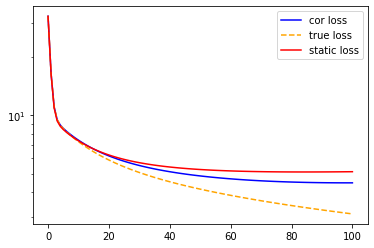

In [24]:
cor_op = get_net_corected_operator(static_op, model,device = device,swaped=c.forward_swaped)
cor_adj_op = get_net_corected_operator(static_op.adjoint, adjoint_model,device = device,swaped=c.adj_swaped)

step = ISTA(c.mu,c.lam,y_e,cor_op,cor_adj_op).get_impl
true_step = ISTA(c.mu,c.lam,y_e,true_op,true_op.adjoint).get_impl
static_step = ISTA(c.mu,c.lam,y_e,static_op,static_op.adjoint).get_impl

x_0 = static_op.adjoint(y_e)
# x_0 = np.zeros((64,64))
# x_0 = p

X_cor = [x_0]
X_true = [x_0]
X_static = [x_0]
cor_loss = [im_norm(X_cor[-1]-p)]
true_loss = [im_norm(X_true[-1]-p)]
static_loss = [im_norm(X_static[-1]-p)]

num_iterations = 100

for j in range(num_iterations):
    X_cor.append(step(X_cor[-1]))
    X_true.append(true_step(X_true[-1]))
    X_static.append(static_step(X_static[-1]))
    cor_loss.append(im_norm(X_cor[-1]-p))
    true_loss.append(im_norm(X_true[-1]-p))
    static_loss.append(im_norm(X_static[-1]-p))

fig,ax = plt.subplots()
ax.plot(cor_loss,'b',label = 'cor loss')
ax.plot(true_loss,'orange',linestyle='--',label = 'true loss')
ax.plot(static_loss,'r',label = 'static loss')
ax.set_yscale('log')
ax.legend()
plt.show(fig)

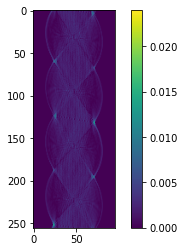

In [37]:
plt.imshow(np.abs(cor_op(np.zeros((64,64)))))
plt.colorbar()

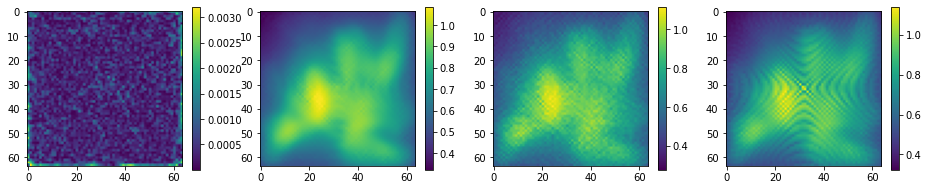

In [32]:
fig, axs = plots(1,4,4/3)
im = axs[0].imshow(np.abs(cor_adj_op(np.zeros((256,96)))))
fig.colorbar(im,ax=axs[0])
im = axs[1].imshow(cor_adj_op(y_e))
fig.colorbar(im,ax=axs[1])
im = axs[2].imshow(true_op.adjoint(y_e))
fig.colorbar(im,ax=axs[2])
im = axs[3].imshow(static_op.adjoint(y_e))
fig.colorbar(im,ax=axs[3])

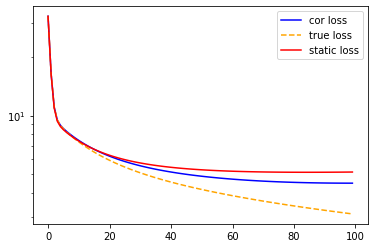

In [33]:
i = 100
fig,ax = plt.subplots()
ax.plot(cor_loss[:i],'b',label = 'cor loss')
ax.plot(true_loss[:i],'orange',linestyle='--',label = 'true loss')
ax.plot(static_loss[:i],'r',label = 'static loss')
ax.set_yscale('log')
# ax.set_ylim([0,10])
ax.legend()
plt.show(fig)

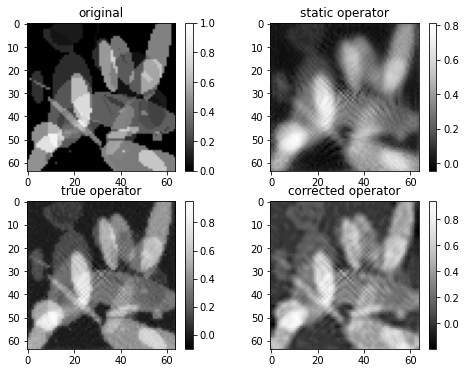

In [34]:
i = 100
fig,axs = plots(2,2,4/3)
axs[0,0].set_title('original')
im = axs[0,0].imshow(p,cmap = 'Greys_r')
fig.colorbar(im,ax=axs[0,0])
axs[1,0].set_title('true operator')
im = axs[1,0].imshow(X_true[i],cmap = 'Greys_r')
fig.colorbar(im,ax=axs[1,0])
axs[0,1].set_title('static operator')
im = axs[0,1].imshow(X_static[25],cmap = 'Greys_r')
fig.colorbar(im,ax=axs[0,1])
axs[1,1].set_title('corrected operator')
im = axs[1,1].imshow(X_cor[i],cmap = 'Greys_r')
fig.colorbar(im,ax=axs[1,1])
plt.show(fig)

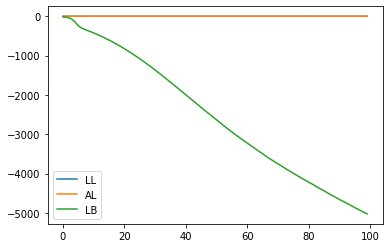

In [38]:
LL = np.zeros(len(X_cor)-1) #L(x)-L(x_Theta) 
AL = np.zeros(len(X_cor)-1) #Alignement
FwL = np.zeros(len(X_cor)-1) #forward Loss
AdL = np.zeros(len(X_cor)-1) #adjoint Loss
ALF = np.zeros(len(X_cor)-1) #adjoint Loss
LB = np.zeros(len(X_cor)-1) #Lowerbound
TM = np.zeros(len(X_cor)-1) #T_Thetah_mu


L = lambda lam,x :ISTA_obj_func(true_op,y_e,lam,x)


for i,x_Theta_p in enumerate(X_cor[1:]):
    x = X_cor[i]
    T_mu = (x-x_Theta_p)/c.mu
    n_T_mu = im_norm(T_mu)
    TM[i] = n_T_mu
    F_abl = true_op.adjoint(true_op(x)-y_e)
    r = cor_op(x)-y_e
    F_Theta_abl = cor_adj_op(r)
    LL[i] = (L(c.lam,x)-L(c.lam,x_Theta_p))
    AL[i] = c.mu*(sp(F_abl-F_Theta_abl,T_mu)+0.5*n_T_mu**2)
    FwL[i] = im_norm(true_op(x)-cor_op(x))
    AdL[i] = im_norm(true_op.adjoint(r)-cor_adj_op(r))
    LB[i] = c.mu*n_T_mu*(0.5*n_T_mu-1/c.lam*(rt_norm*FwL[i]+AdL[i]))
plt.plot(LL/TM**2,label='LL')
plt.plot(AL/TM**2,label='AL')
plt.plot(LB/TM**2,label='LB')
# plt.yscale('log')
plt.legend()

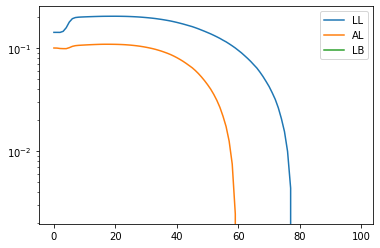

In [39]:
i = 100
plt.plot(LL[:i]/TM[:i]**2,label='LL')
plt.plot(AL[:i]/TM[:i]**2,label='AL')
plt.plot(LB[:i]/TM[:i]**2,label='LB')
plt.yscale('log')
plt.legend()

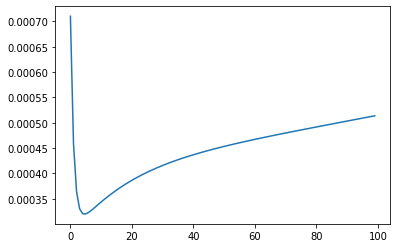

In [42]:
plt.plot(FwL/64**2)

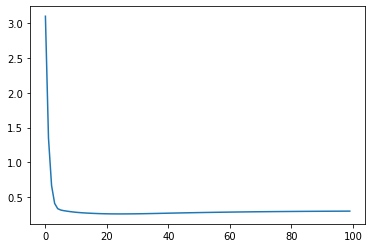

In [41]:
plt.plot(AdL)

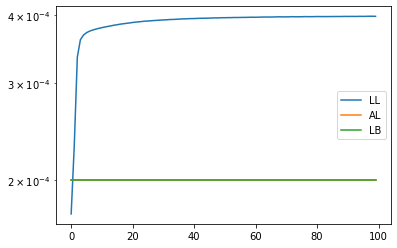

In [18]:
LL = np.zeros(len(X_cor)-1) #L(x)-L(x_Theta) 
AL = np.zeros(len(X_cor)-1) #Alignement
FwL = np.zeros(len(X_cor)-1) #forward Loss
AdL = np.zeros(len(X_cor)-1) #adjoint Loss
ALF = np.zeros(len(X_cor)-1) #adjoint Loss
LB = np.zeros(len(X_cor)-1) #Lowerbound
TM = np.zeros(len(X_cor)-1) #T_Thetah_mu


L = lambda lam,x :ISTA_obj_func(true_op,y_e,lam,x)

op = true_op
adj_op = true_op.adjoint
X = X_true
for i,x_Theta_p in enumerate(X[1:]):
    x = X[i]
    T_mu = (x-x_Theta_p)/c.mu
    n_T_mu = im_norm(T_mu)
    TM[i] = n_T_mu
    F_abl = true_op.adjoint(true_op(x)-y_e)/c.lam
    r = op(x)-y_e
    F_Theta_abl = adj_op(r)/c.lam
    LL[i] = (L(c.lam,x)-L(c.lam,x_Theta_p))
    AL[i] = c.mu*(sp(F_abl-F_Theta_abl,T_mu)+0.5*n_T_mu**2)
    FwL[i] = im_norm(true_op(x)-op(x))
    AdL[i] = im_norm(true_op.adjoint(r)-adj_op(r))
    LB[i] = c.mu*n_T_mu*(0.5*n_T_mu-1/c.lam*(rt_norm*FwL[i]+AdL[i]))
plt.plot(LL/TM**2,label='LL')
plt.plot(AL/TM**2,label='AL')
plt.plot(LB/TM**2,label='LB')
plt.yscale('log')
plt.legend()

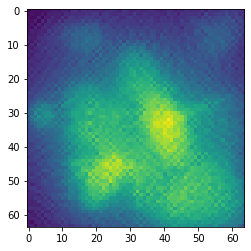

In [19]:
plt.imshow(true_step(np.zeros((64,64))))


In [59]:
x = np.random.rand(10)-0.5
np.sign(x) * np.maximum(np.abs(x)-0.1,0)

array([-0.03011308,  0.17552713,  0.16560468,  0.04560411, -0.37258231,
        0.        , -0.09025499, -0.30304146, -0.2431009 ,  0.22550922])

In [81]:
np.save('Test.npy',{'LL':LL,'AL':AL,'TM':TM})

In [85]:
a = np.load('Test.npy',allow_pickle=True).item()

In [86]:
a.get('LL')

array([  1.28814957e+06,   1.33362044e+04,   1.30183322e+03,
         9.92546546e+02,   7.70867791e+02,   6.06030681e+02,
         4.83022325e+02,   3.89275008e+02,   3.17050695e+02,
         2.61002793e+02,   2.16533629e+02,   1.80642485e+02,
         1.51446292e+02,   1.27594344e+02,   1.08247399e+02,
         9.22846071e+01,   7.90534989e+01,   6.81584251e+01,
         5.90788757e+01,   5.12858256e+01,   4.47052945e+01,
         3.91477616e+01,   3.44589003e+01,   3.03181363e+01,
         2.69093799e+01,   2.38717149e+01,   2.13023689e+01,
         1.89520620e+01,   1.69522673e+01,   1.50312853e+01,
         1.33956493e+01,   1.19513855e+01,   1.06970759e+01,
         9.58604479e+00,   8.57289156e+00,   7.69985069e+00,
         6.97820370e+00,   6.23895702e+00,   5.58226380e+00,
         5.01926345e+00,   4.50533611e+00,   4.07176132e+00,
         3.67599210e+00,   3.28697259e+00,   2.95420285e+00,
         2.62491876e+00,   2.33941704e+00,   2.09492061e+00,
         1.83097964e+00,

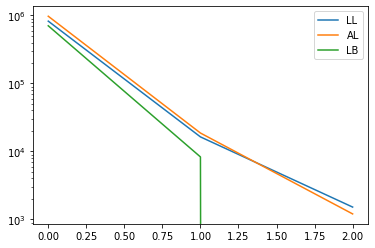

In [31]:
i = 3
plt.plot(LL[:i],label='LL')
plt.plot(AL[:i],label='AL')
plt.plot(LB[:i],label='LB')
plt.yscale('log')
plt.legend()

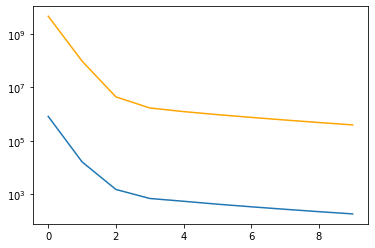

In [34]:
plt.plot(TM[:10]**2,'orange')
plt.plot(LL[:10])
plt.yscale('log')

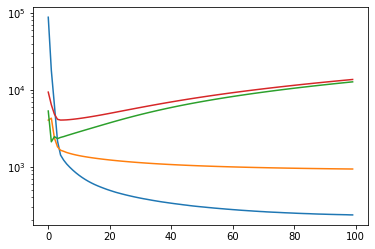

In [93]:
x =  np.array(X_cor).reshape(101,64**2)
# plt.plot(np.linalg.norm(x[1:]-x[:-1],2,1)/c.mu)
plt.plot(TM)
plt.plot(AdL/c.lam)
plt.plot(rt_norm*FwL/c.lam)
plt.plot((rt_norm*FwL+AdL)/c.lam)
plt.yscale('log')

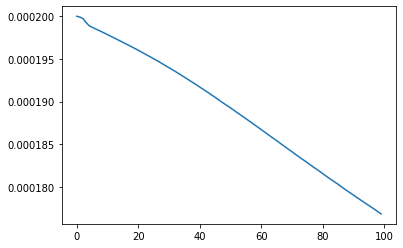

In [90]:
plt.plot(c.mu*(0.5-(rt_norm*FwL+AdL)/TM))

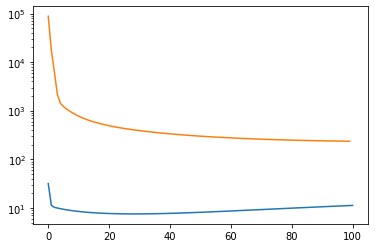

In [79]:
plt.plot(np.linalg.norm(x-np.array([p.reshape(64**2)]*101),2,1))
plt.plot(TM)
plt.yscale('log')

In [65]:
X_cor

[array([[ 0.31461084,  0.31592218,  0.31212856, ...,  0.44720637,
          0.43126523,  0.42017339],
        [ 0.31101557,  0.32001983,  0.32126421, ...,  0.48100031,
          0.46787214,  0.41557912],
        [ 0.31390816,  0.32232463,  0.32544323, ...,  0.50250121,
          0.46424143,  0.43225792],
        ..., 
        [ 0.52938479,  0.56817632,  0.59158829, ...,  0.60845057,
          0.57969691,  0.5431329 ],
        [ 0.52310354,  0.567776  ,  0.57548922, ...,  0.59090481,
          0.57689262,  0.53699229],
        [ 0.49748517,  0.51148554,  0.538573  , ...,  0.56532602,
          0.54422255,  0.52073871]]),
 array([[ 0.08244302,  0.01947611,  0.00465616, ...,  0.12716767,
          0.14815158,  0.22228322],
        [ 0.05727852,  0.00768125, -0.01589266, ...,  0.12982793,
          0.13348413,  0.12327714],
        [ 0.02408469, -0.01534311, -0.04720242, ...,  0.14947256,
          0.11303546,  0.1180625 ],
        ..., 
        [ 0.23100701,  0.24635213,  0.21894137, ...,

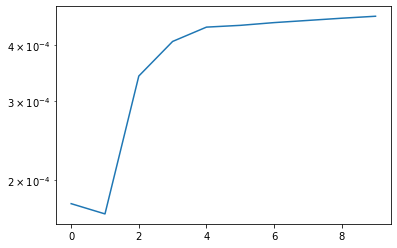

In [35]:
plt.plot(LL[:10]/TM[:10]**2)
plt.yscale('log')

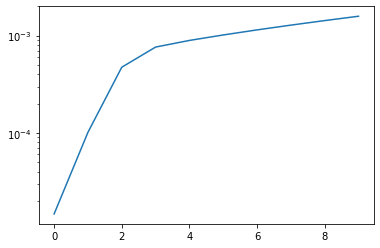

In [37]:
plt.plot(1/TM[:10])
plt.yscale('log')

In [44]:
AL.shape

(100,)

In [40]:
T = np.array([[1,2],[3,4]])

In [43]:
np.sum(T,1)

array([3, 7])

(-1.0, 1.0)

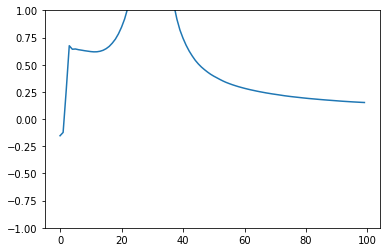

In [49]:
plt.plot((LL-AL)/np.abs(AL))
plt.ylim([-1,1])

In [50]:
(LL-AL)/np.abs(AL)

array([ -0.15322491,  -0.12267705,   0.26086275,   0.67471515,
         0.64244525,   0.64472355,   0.63825513,   0.63377992,
         0.62882895,   0.62479467,   0.62071077,   0.61836353,
         0.61902026,   0.62374865,   0.6327014 ,   0.64763656,
         0.66871178,   0.69874066,   0.73525862,   0.78393143,
         0.84521723,   0.92012485,   1.01901634,   1.14907025,
         1.33431793,   1.59803698,   1.99895591,   2.70410542,
         4.15192945,   9.40270382,  33.24930879,   6.10756986,
         3.39631643,   2.37012132,   1.81464426,   1.46317809,
         1.21708488,   1.05262029,   0.92023987,   0.81876941,
         0.74367216,   0.67962346,   0.62582696,   0.58056037,
         0.53995795,   0.50672695,   0.47823244,   0.45410189,
         0.4319403 ,   0.41184963,   0.39482148,   0.37980518,
         0.36456467,   0.35033549,   0.33753652,   0.32674323,
         0.31644239,   0.30724169,   0.29840922,   0.29056818,
         0.28291001,   0.27591805,   0.2692615 ,   0.26

In [25]:
LL >= AL

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True], dtype=bool)

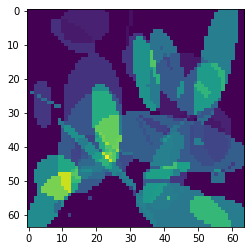

In [17]:
y = error_for_y(A_s@p.reshape(64**2),0)
x = sparse.linalg.spsolve(A_s.T@A_s+0*sparse.eye(64**2),A_s.T@y)
plt.imshow(x.reshape(64,64))

In [52]:
im_norm(y-A_s@p.reshape(64**2))/im_norm(A_s@p.reshape(64**2)),im_norm(x-p.reshape(64**2))/im_norm(p)


(0.10000000000000001, 0.54118855709738378)

In [47]:
im_norm(y-A_s@p.reshape(64**2))*rt_norm,im_norm(x-p.reshape(64**2))


(4.7816652907060249, 4.4760313520393691)

In [50]:
im_norm(A_s@p.reshape(64**2)),im_norm(p)*rt_norm

(28.029118374180161, 36.162356931537751)

In [39]:
(A_s@p.reshape(p.size))

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [43]:
num_points = 42
loss = []
x_static = list()
x_static_nn = list()
y_e = error_for_y(A_s@p.reshape(64**2),0.01)
for j,lam in enumerate(np.logspace(1,-4,num_points)):
    x_static.append(sparse.linalg.spsolve(A_static_s.T@A_static_s+lam*sparse.eye(64**2),A_static_s.T@y_e.reshape(y_e.size)))
    x_static_nn.append(sparse.linalg.spsolve(A_static_s.T@A_static_s+lam*sparse.eye(64**2),A_static_s.T@(A_s@p.reshape(p.size))))
    loss.append([im_norm(p-x_static[-1].reshape(64,64)),
                im_norm(p-x_static_nn[-1].reshape(64,64)),
                im_norm(x_static[-1]-x_static_nn[-1])
                ])
    
    print(f'{100*(j+1)/num_points:0}%',end="\r")

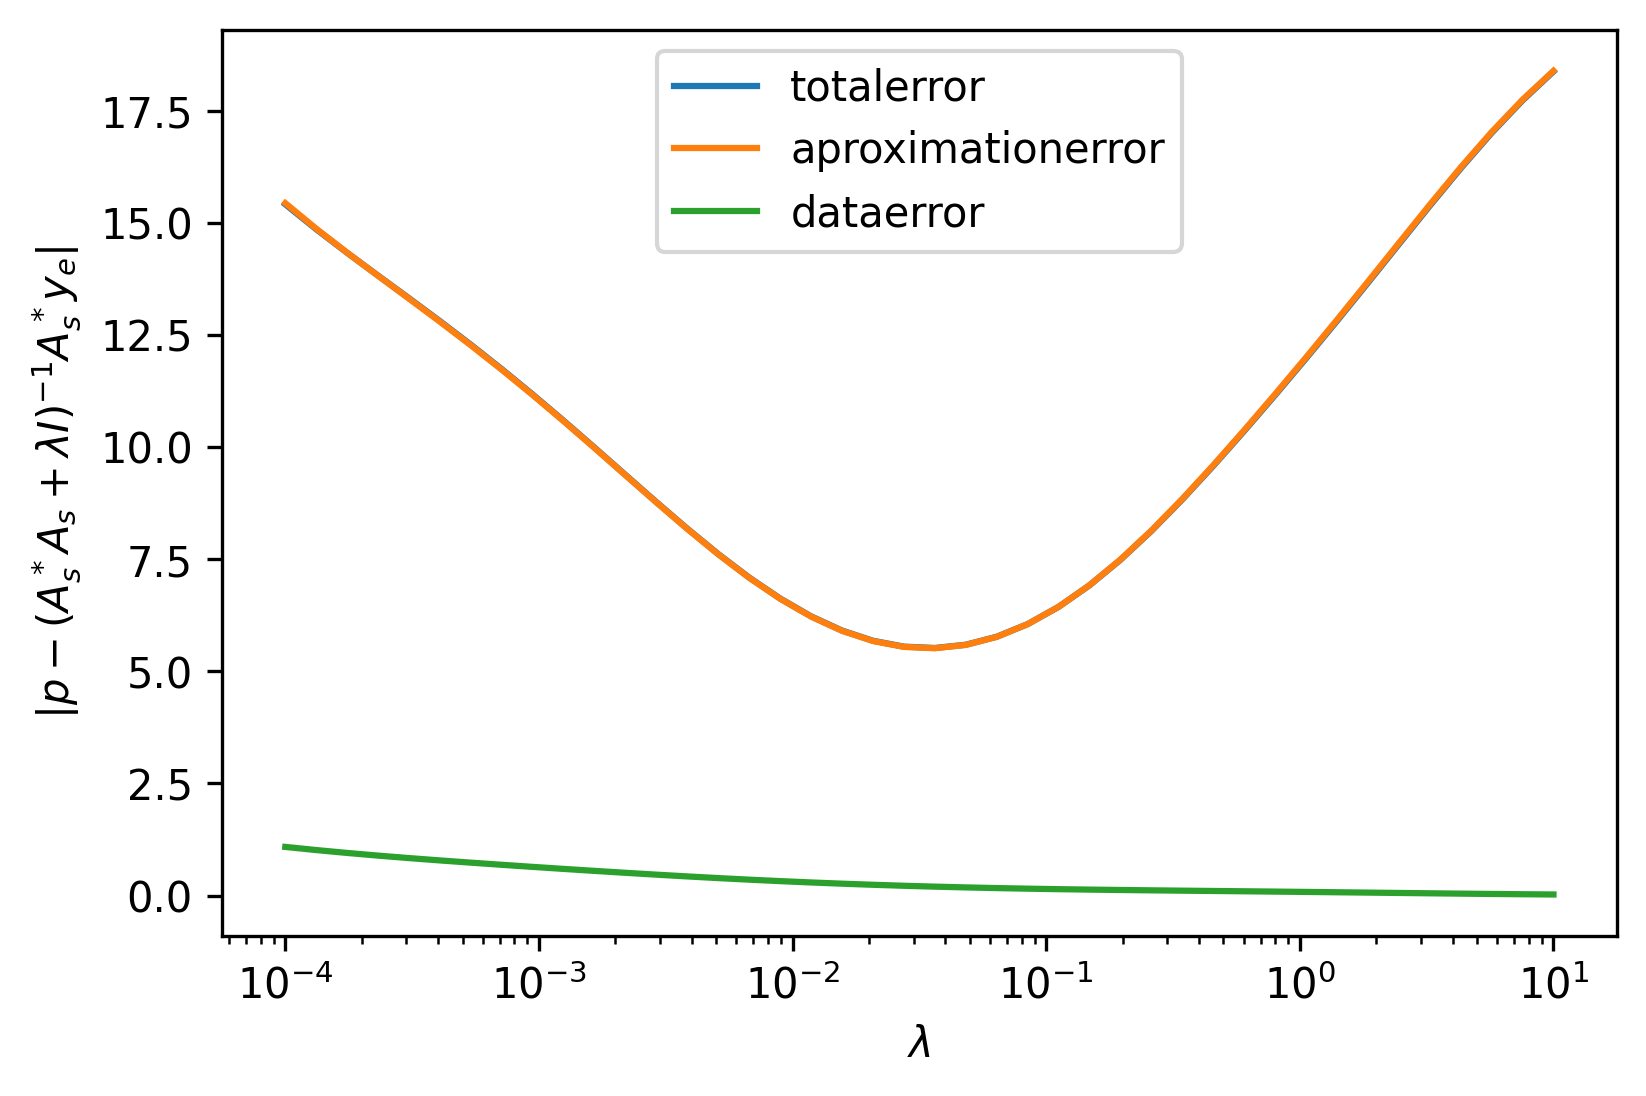

In [50]:
fig = plt.figure()
plt.plot(np.logspace(1,-4,num_points),loss)
plt.legend(['totalerror','aproximationerror','dataerror'])
plt.xlabel('$\lambda$')
plt.ylabel('$\|p-(A_s^*A_s+\lambda I)^{-1}A_s^*y_e\|$')
plt.xscale('log')
fig.set_dpi(300)

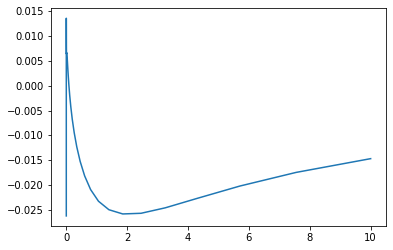

In [49]:
n_loss = np.array(loss)
n_loss.shape
plt.plot(np.logspace(1,-4,num_points),n_loss[:,0]-n_loss[:,1])

0.0199526231496888

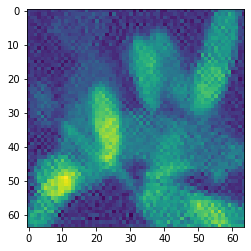

In [ ]:
x_static = sparse.linalg.spsolve(A_static_s.T@A_static_s+10**-1.7*sparse.eye(64**2),A_static_s.T@y_e.reshape(y_e.size))
plt.imshow(x_static.reshape(64,64))

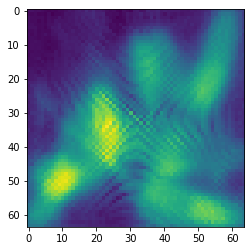

In [131]:
x_static = sparse.linalg.spsolve(A_static_s.T@A_static_s+1/rt_norm*sparse.eye(64**2),A_static_s.T@y_e.reshape(y_e.size))
plt.imshow(x_static.reshape(64,64))

In [20]:
(LL-AL)[0]

-25764.800091052544

In [13]:
from Dataset import Datensatz

In [15]:
c.shift_params_list = [c.shift_params]

In [16]:
D = Datensatz(c,static_op,device)

100%|██████████| 4096/4096 [01:45<00:00, 38.95it/s]


In [17]:
from Iteration_Steps import ISTA_step
step_op = ISTA_step(c.mu,c.lam)

In [18]:
D.update_x_is(model,adjoint_model,6,step_op)

In [19]:
length = len(D.val_x_is[0][1][0][1])

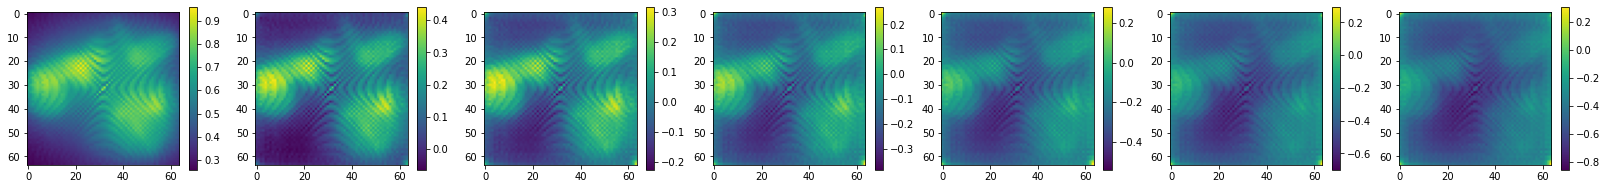

In [21]:
fig,axs = plots(1,length,4/3)
for i,img in enumerate(D.val_x_is[0][1][0][1]):
    im = axs[i].imshow(img)
    fig.colorbar(im,ax=axs[i])

In [72]:
one = np.ones((64,64))

In [76]:
from Dataset import Xis_Y_iterator

In [80]:
fw_model = model
adj_model = adjoint_model
iteration = 6

In [86]:
self = D
if step_op is None:
    step_op = self.step_op
cor_op = get_net_corected_operator(self.static_op, fw_model,device = self.device,swaped=self.c.forward_swaped)
cor_adj_op = get_net_corected_operator(self.static_op.adjoint, adj_model,device = self.device,swaped=self.c.adj_swaped)
get_x_0 = self.x_0_chooser(self.c.x_0_selection_rule)
for y,l in Xis_Y_iterator(self.fixed_train_x_is):
    F_abl = lambda x: cor_adj_op(cor_op(x)-y)
    l.clear()
    l.append(get_x_0(y))
    for i in range(1,iteration+1):
        l.append(step_op(l[-1],F_abl(l[-1])))

for y,l in Xis_Y_iterator(self.rand_train_x_is):
    F_abl = lambda x: cor_adj_op(cor_op(x)-y)
    l.clear()
    l.append(get_x_0(y))
    for i in range(1,iteration+1):
        l.append(step_op(l[-1],F_abl(l[-1])))

for y,l in Xis_Y_iterator(self.val_x_is):
    F_abl = lambda x: cor_adj_op(cor_op(x)-y)
    l.clear()
    l.append(get_x_0(y))
    for i in range(1,iteration+1):
        l.append(step_op(l[-1],F_abl(l[-1])))

TypeError: ISTA.get_impl() takes 2 positional arguments but 3 were given

In [108]:
def soft_shrink(x,alpha):
    """the soft shrinkige operator
    Args:
        x (np.array): input
        alpha (): parameter

    Returns:
        np.array: soft_schrink(x)
    """
    return np.sign(x) * np.maximum(np.abs(x)-alpha,0)

In [109]:
def ISTA_step(mu,lam):
    
    def step(x,F_abl_x):
        x = soft_shrink(x-mu/lam*F_abl_x,mu)
        return x
    return step

In [110]:
step_op = ISTA_step(c.mu,c.lam)

In [111]:
for y,l in Xis_Y_iterator(self.val_x_is):
    F_abl = lambda x: cor_adj_op(cor_op(x)-y)
    l.clear()
    l.append(get_x_0(y))
    for i in range(1,iteration+1):
        l.append(step_op(l[-1],F_abl(l[-1])))

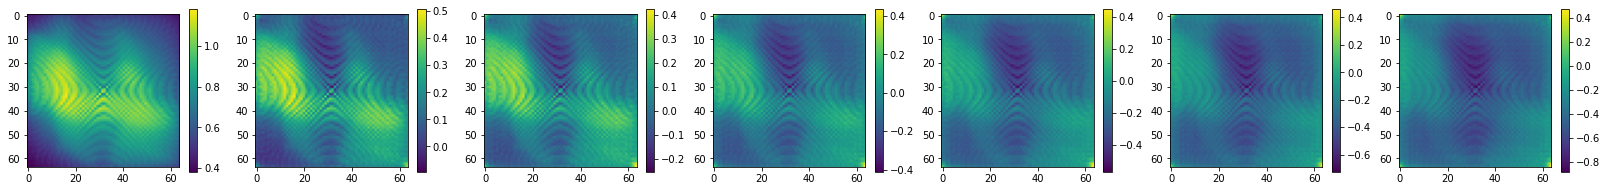

In [112]:
fig,axs = plots(1,length,4/3)
for i,img in enumerate(l):
    im = axs[i].imshow(img)
    fig.colorbar(im,ax=axs[i])

In [106]:
step = ISTA(c.mu,c.lam,y_e,cor_op,cor_adj_op).get_impl

for y,l in Xis_Y_iterator(self.val_x_is):
    F_abl = lambda x: cor_adj_op(cor_op(x)-y)
    l.clear()
    l.append(get_x_0(y))
    for i in range(1,iteration+1):
        l.append(step(l[-1]))

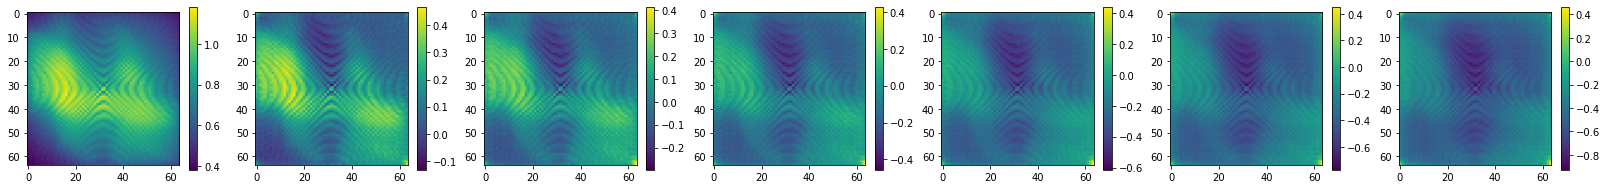

In [107]:
fig,axs = plots(1,length,4/3)
for i,img in enumerate(l):
    im = axs[i].imshow(img)
    fig.colorbar(im,ax=axs[i])

In [104]:
for y,l in Xis_Y_iterator(self.val_x_is):
    step = ISTA(self.c.mu,self.c.lam,y,cor_op,cor_adj_op).get_impl
    l.clear()
    l.append(get_x_0(y))
    for i in range(1,iteration+1):
        l.append(step(l[-1]))

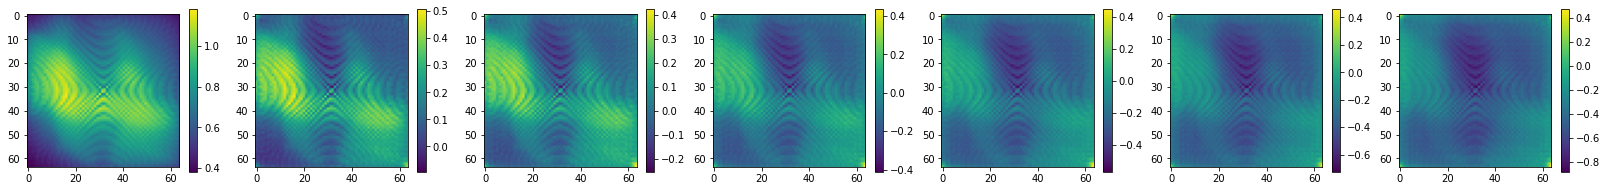

In [105]:
fig,axs = plots(1,length,4/3)
for i,img in enumerate(l):
    im = axs[i].imshow(img)
    fig.colorbar(im,ax=axs[i])

{'run_name': 'run_20220807_matrix_ISTA',
 'path': 'runs/run_20220807_matrix_ISTA/',
 'f': <_io.TextIOWrapper name='runs/run_20220807_matrix_ISTA/conf_dict.json' mode='r' encoding='cp1252'>,
 'd': {'note': 'run on ISTA refine on just random operators ',
  'run_name': 'run_20220807_matrix_ISTA',
  'step_type': 'ISTA',
  'path': 'runs/run_20220807_matrix_ISTA/',
  'gpu_index': 0,
  'fileending': 'svg',
  'phantoms_path': 'phantoms/',
  'train_phantom_path': 'phantoms/train_phantoms_64_1000.npy',
  'val_phantom_path': 'phantoms/validation_phantoms_64_10.npy',
  'test_phantom_path': 'phantoms/test_phantoms_64_1.npy',
  'val_op_paths': ['Matritzen/64_64_256_96_rand_shift_val.npz'],
  'doent_show': True,
  'model_path': 'runs/run_20220807_matrix_ISTA/models/',
  'test_the_model': False,
  'device': 'check',
  'start_iteration': 50,
  'num_iterations': 100,
  'num_epoch_list': [8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,
   8,


In [140]:
import odl

In [150]:
grad = odl.discr.Gradient(ray_trafo.domain)
div = grad.adjoint

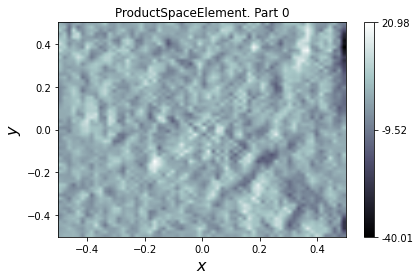

<Figure size 432x288 with 0 Axes>

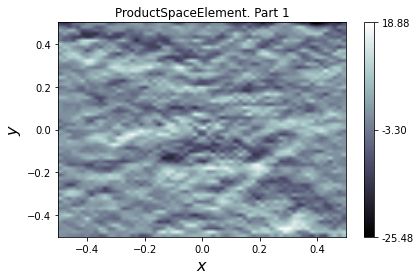

<Figure size 432x288 with 0 Axes>

In [154]:
grad(x).show();

In [157]:
huber = odl.solvers.Huber(grad.range,0.001)

In [158]:
Huber_TV = odl.OperatorComp(huber,grad)

In [166]:
Huber_TV.derivative(x)

OperatorComp(InnerProductOperator(ProductSpace(uniform_discr([-0.5, -0.5], [ 0.5,  0.5], (64, 64)), 2).element([
    
        [[-0.        , -0.36217069, -0.75714906, ...,  0.88963059,  0.75749532,
           0.11415261],
         [ 0.975522  ,  0.86103492,  0.70710678, ..., -0.98424817,  0.57277536,
          -0.12272554],
         [ 0.63827851,  1.        ,  0.94521658, ..., -0.91998039, -0.75604042,
          -0.49132088],
         ..., 
         [-0.49635018, -0.87510266, -0.91212639, ..., -0.36835623, -0.58536525,
           0.15744684],
         [-0.99508944, -0.56158644, -0.28856134, ..., -0.63443878, -0.97945333,
          -0.39568729],
         [-0.78099391, -0.84607795, -0.99984783, ..., -0.94752009, -0.9638442 ,
          -0.70710678]],
    
        [[-0.        ,  0.93211179, -0.65324215, ...,  0.45668086, -0.6528406 ,
          -0.99346323],
         [-0.21990187,  0.50854584,  0.70710678, ...,  0.17679237, -0.81971238,
          -0.99244065],
         [-0.76980552,  0.   

In [177]:
type(np.array([x]))

numpy.ndarray

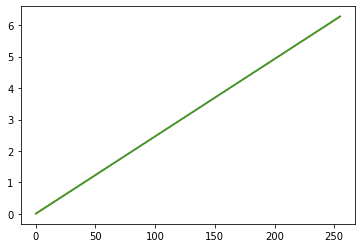

In [189]:
plt.plot(static_ray_trafo.geometry.angles)
plt.plot(ray_trafo.geometry.angles)
plt.plot(np.linspace(0,2*np.pi,256))

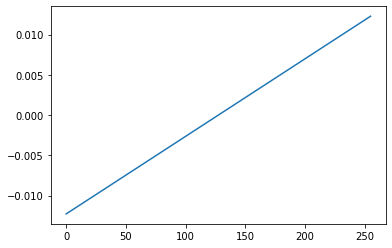

In [190]:
plt.plot(np.linspace(0,2*np.pi,256)-ray_trafo.geometry.angles)

In [183]:
shift(static_ray_trafo.geometry.angles)

array([[  2.79830840e-02,   1.10302254e-02],
       [  3.21407149e-03,   1.14151475e-03],
       [ -3.01396256e-02,  -8.81938887e-03],
       [  1.70086762e-02,  -1.82225269e-02],
       [  1.87273350e-02,  -2.64732158e-02],
       [ -2.95741332e-02,  -3.30496562e-02],
       [  1.11598498e-03,  -3.75359336e-02],
       [  2.88253422e-02,  -3.96483220e-02],
       [ -2.04568895e-02,  -3.92532273e-02],
       [ -1.50994081e-02,  -3.63756365e-02],
       [  3.05881208e-02,  -3.11975374e-02],
       [ -5.42426593e-03,  -2.40464091e-02],
       [ -2.69486078e-02,  -1.53745112e-02],
       [  2.35059403e-02,  -5.73028140e-03],
       [  1.11768558e-02,   4.27634918e-03],
       [ -3.10052615e-02,   1.40125302e-02],
       [  9.62670657e-03,   2.28625152e-02],
       [  2.45460420e-02,   3.02666037e-02],
       [ -2.60963343e-02,   3.57565381e-02],
       [ -7.03621654e-03,   3.89851180e-02],
       [  3.08174159e-02,   3.97481579e-02],
       [ -1.36413073e-02,   3.79974007e-02],
       [ -

In [184]:
type(A_static_s)

scipy.sparse._csr.csr_matrix

(0.0, 2.0)

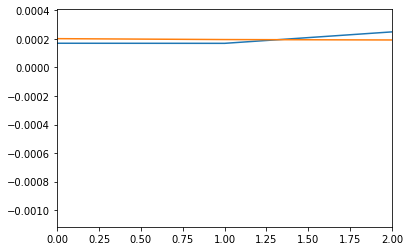

In [18]:
dic = np.load(c.path + 'Test/test_dict_iter_49.npy',allow_pickle=True).item()
plt.plot(dic.get('LL')/dic.get('TM')**2)
plt.plot(dic.get('AL')/dic.get('TM')**2)
plt.xlim([0,2])
